In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

import torch
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from CapsuleNet_bbox import CapsuleNetwork, CapsuleLoss, display_images
from utils_original_bbox import DICOMCoarseDataset, display_data_loader_batch, TransformBboxDataset  ,CustomTransform

In [2]:
scenario = 1
data_augmentation = False

In [3]:
BASE_DIR = "D:/Datasets/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
classes = ["nodule", "non-nodule"]
train_ratio = 0.8
image_size = 80
df_bbox_coord = pd.read_csv('annotation_files.csv')
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

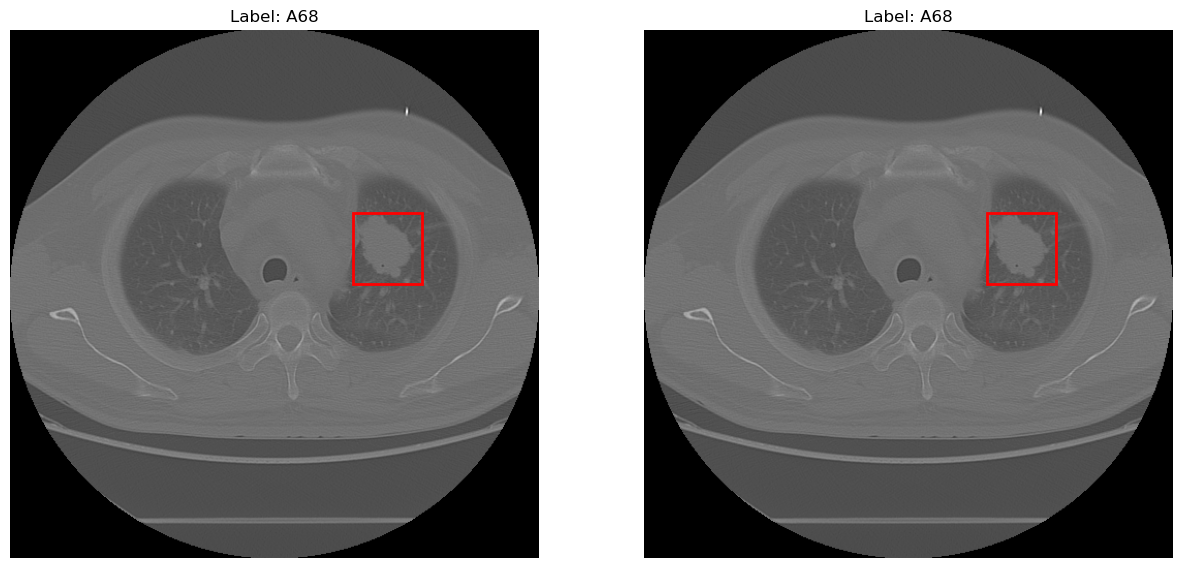

In [4]:
dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "A68"))), classes=["A68", "A68"], bbox_coord=df_bbox_coord, scenario=scenario)
dataset.visualize_images(num_images=7)

C:\Users\chris\AppData\Local\Temp\ipykernel_10528\1514618796.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load('dataset.pt')


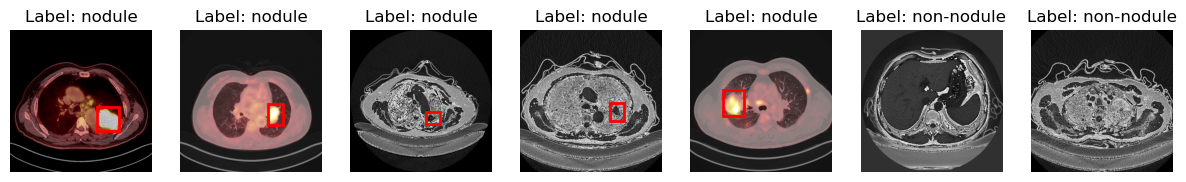

In [4]:
# train_transforms = None

# transform = transforms.Compose([
#     transforms.Resize((image_size, image_size)),
#     transforms.Grayscale(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])

# if data_augmentation:
#     train_transforms = transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(degrees=15),        # Rotate by up to ±15 degrees
#         transforms.RandomResizedCrop((224, 224),      # Random crop and resize to simulate zooming
#                         scale=(0.8, 1.2),  # Scale for zoom in/out
#                         ratio=(0.9, 1.1)),
#         transforms.RandomAffine(degrees=0, shear=10), # Apply random shear with ±10 degrees
#         transform
#     ])
# else: 
#     train_transforms = transform
dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=["nodule", "non-nodule"], bbox_coord=df_bbox_coord, scenario=scenario)

# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=["nodule", "non-nodule"], transform=transform, scenario=1)
# torch.save(dataset, 'dataset.pt')
dataset = torch.load('dataset.pt')
dataset.visualize_images(num_images=7)

In [5]:
image, _, _ = dataset[50050]
orig_width, orig_height = image.size

type(image_size)

int

In [6]:
_, _, annotations = dataset[50000]
xmin = annotations['xmin']
type(xmin)


int

In [7]:
image=dataset[50050]

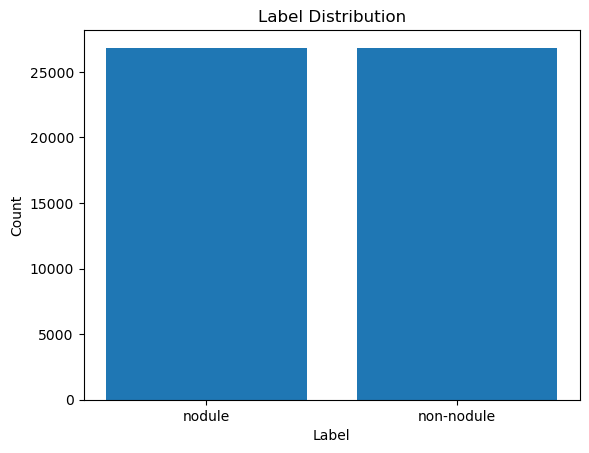

In [8]:
dataset.display_label_distribution()

In [9]:
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataset = TransformBboxDataset(torch.utils.data.Subset(dataset, train_dataset.indices), transform=CustomTransform(image_size))
test_dataset = TransformBboxDataset(torch.utils.data.Subset(dataset, test_dataset.indices), CustomTransform(image_size))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [10]:
train_dataset[4]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 0,
 (21.40625, 45.0, 28.28125, 55.78125))

In [11]:
data_iter = iter(train_loader)
batch = next(data_iter)
batch

[tensor([[[[-0.6235, -0.6235, -0.6235,  ..., -0.6235, -0.6235, -0.6235],
           [-0.6235, -0.6235, -0.6235,  ..., -0.6235, -0.6235, -0.6235],
           [-0.6235, -0.6235, -0.6235,  ..., -0.6235, -0.6235, -0.6235],
           ...,
           [-0.6235, -0.6235, -0.6235,  ..., -0.6235, -0.6235, -0.6235],
           [-0.6235, -0.6235, -0.6235,  ..., -0.6235, -0.6235, -0.6235],
           [-0.6235, -0.6235, -0.6235,  ..., -0.6235, -0.6235, -0.6235]]],
 
 
         [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],
 
 
         [[[-0.8588, -0.8588, -0.8588,  ..., -0.8588, -0.8588, -0.8588],
       

In [12]:
# Lade das erste Batch
data_iter = iter(train_loader)
images, labels, bbox = next(data_iter)
bboxes = torch.stack([torch.stack(b) for b in zip(*bbox)], dim=0) 
bboxes=bboxes.float()
bboxes.dtype


torch.float32

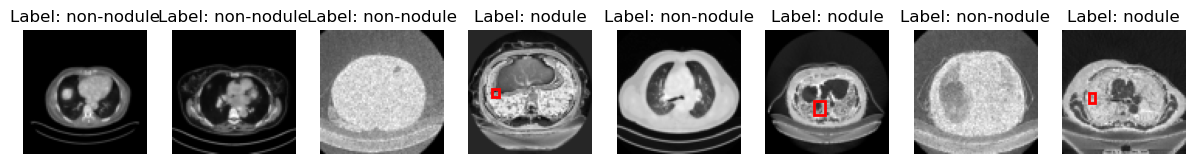

In [13]:
display_data_loader_batch(train_loader, classes)

In [14]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=6400, bias=True)
      (5): Sigmoid()
    )
    (linear_boxes_layers): Sequential(
      (0): Linear(in_features=32768, out_features=1024, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1024, out_features=256, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=256, out_features=64, bias=True)
      (5): ReLU(inplace=True)
      (6): Linear(in_features=64, out_features=4, bias=Tru

In [15]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [16]:
n_epochs = 5
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)

Epoch: 1 	Training Loss: 78.61001205
Epoch: 1 	Training Loss: 34.42123032
Epoch: 1 	Training Loss: 50.05614853
Epoch: 1 	Training Loss: 32.44253540
Epoch: 1 	Training Loss: 35.49992371
Epoch: 1 	Training Loss: 26.90851593
Epoch: 1 	Training Loss: 39.40231705
Epoch: 1 	Training Loss: 40.12372208
Epoch: 1 	Training Loss: 26.75940704
Epoch: 1 	Training Loss: 45.08245850
Epoch: 1 	Training Loss: 34.34704971
Epoch: 1 	Training Loss: 27.99703979
Epoch: 1 	Training Loss: 34.81214142
Epoch: 1 	Training Loss: 31.03886795
Epoch: 1 	Training Loss: 37.20855331
Epoch: 1 	Training Loss: 43.91805267
Epoch: 1 	Training Loss: 35.37354279
Epoch: 1 	Training Loss: 33.38724899
Epoch: 1 	Training Loss: 38.70373917
Epoch: 1 	Training Loss: 38.53551483
Epoch: 1 	Training Loss: 26.41828346
Epoch: 1 	Training Loss: 23.65549088
Epoch: 1 	Training Loss: 27.02436256
Epoch: 1 	Training Loss: 31.92138481
Epoch: 1 	Training Loss: 41.66628265
Epoch: 1 	Training Loss: 41.64403152
Epoch: 1 	Training Loss: 29.36491394
E

In [ ]:
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

ValueError: too many values to unpack (expected 2)

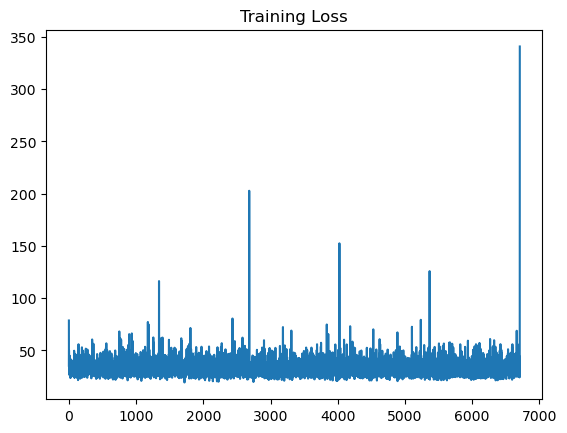

In [17]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

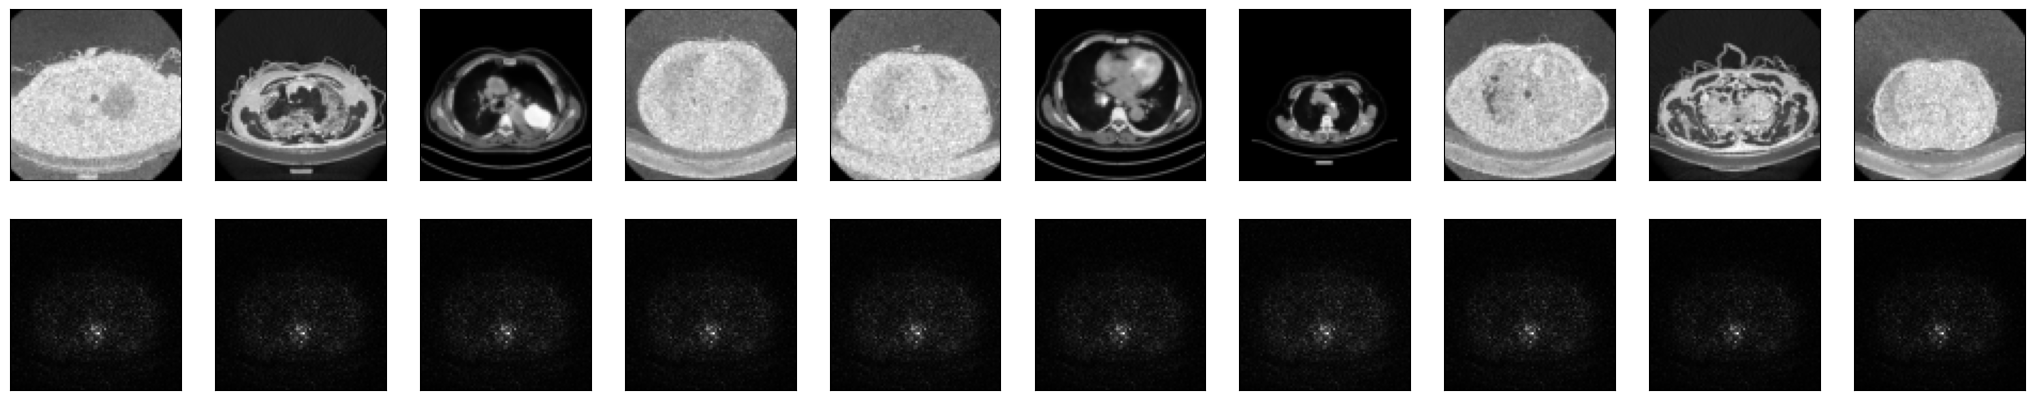

In [13]:
display_images(images, reconstructions)